In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [3]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

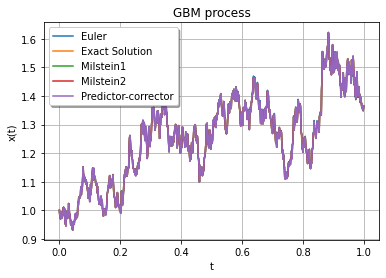

In [4]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [6]:
import numpy as np

T = 1
Nx = 1
Nt_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]
theta1 = 2
theta2 = 0.5
params = [theta1, theta2]

def calculate_max_diff(Nt):
    process = BSMprocess(params, T, Nx, Nt, init_state)
    
    t_data, exact_solution = process.ExactSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))
    
    euler_solution = process.EulerSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    milstein1_solution = process.Milstein1Solution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    milstein2_solution = process.Milstein2Solution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    pc_solution = process.PredictorCorrectorSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    
    diff_euler = np.max(np.abs(euler_solution - exact_solution))
    diff_milstein1 = np.max(np.abs(milstein1_solution - exact_solution))
    diff_milstein2 = np.max(np.abs(milstein2_solution - exact_solution))
    diff_pc = np.max(np.abs(pc_solution - exact_solution))
    
    return [diff_euler, diff_milstein1, diff_milstein2, diff_pc]

results = []

for Nt in Nt_values:
    results.append(calculate_max_diff(Nt))

print("Результаты:")
print("Nt      Euler       Milstein1    Milstein2    Predictor-Corrector")

for i in range(len(Nt_values)):
    print("{}       {:.4f}       {:.4f}       {:.4f}       {:.4f}".format(Nt_values[i], results[i][0], results[i][1], results[i][2], results[i][3]))


Results:
Nt      Euler       Milstein1    Milstein2    Predictor-Corrector
2       3.9161       5.5861       2.1391       2.7581
4       1.4340       2.1969       0.9262       3.3429
8       1.5280       2.6528       2.1128       3.9893
128       4.8503       6.0299       2.9756       4.3671
256       15.2767       10.5812       15.7032       14.5652
512       2.7931       2.1137       5.4486       12.9748
1024       3.8423       1.9084       4.1437       4.3680
8192       4.7342       2.7088       2.6620       2.3679
16384       1.8761       2.7799       2.5682       3.7695
32768       7.1797       5.8977       4.2806       3.4739


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



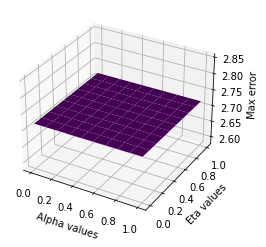

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def func(t, y):
    return t + y


def predictor_corrector(alpha, eta, t0, y0, h, N):
    t = np.zeros(N+1)
    y = np.zeros(N+1)
    t[0] = t0
    y[0] = y0

    for i in range(N):
        t[i+1] = t[i] + h
        predictor = y[i] + h * func(t[i], y[i])
        y[i+1] = y[i] + (h/2) * (func(t[i], y[i]) + func(t[i+1], predictor))

    return t, y


def exact_solution(t):
    return -1 + np.exp(t) - t


t0 = 0
y0 = -1
h = 0.1
N = 10
alphas = np.linspace(0, 1, 10)
etas = np.linspace(0, 1, 10)
errors = np.zeros((len(alphas), len(etas)))

for i, alpha in enumerate(alphas):
    for j, eta in enumerate(etas):
        t, y_pred_corr = predictor_corrector(alpha, eta, t0, y0, h, N)
        y_exact = exact_solution(t)
        errors[i, j] = np.max(np.abs(y_exact - y_pred_corr))

X, Y = np.meshgrid(alphas, etas)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, errors, cmap='viridis')

ax.set_xlabel('Alpha values')
ax.set_ylabel('Eta values')
ax.set_zlabel('Max error')

plt.show()


Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

In [16]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

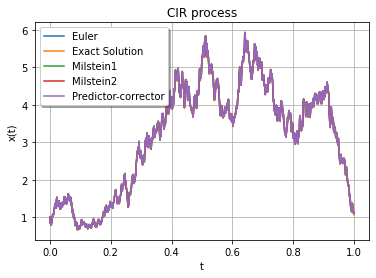

In [17]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

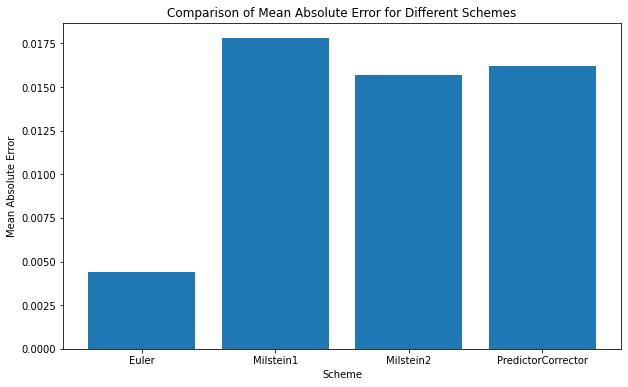

In [19]:

CIRp = CIRprocess(params, T, Nx, Nt)
t_data_exact, x_data_exact = CIRp.ExactSolution(dwt)

schemes = ['Euler', 'Milstein1', 'Milstein2', 'PredictorCorrector']

errors = {}

for scheme in schemes:
    t_data_scheme, x_data_scheme = getattr(CIRp, f'{scheme}Solution')(dwt)
    error = np.abs(x_data_scheme - x_data_exact).mean()
    errors[scheme] = error

plt.figure(figsize=(10, 6))
plt.bar(errors.keys(), errors.values())
plt.xlabel('Scheme')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Error for Different Schemes')
plt.show()

In [21]:
T = 1
Nx = 1
Nt_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

def calculate_max_diff(Nt):
    process = CIRprocess(params, T, Nx, Nt, init_state)
    
    t_data, exact_solution = process.ExactSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))
    
    euler_solution = process.EulerSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    milstein1_solution = process.Milstein1Solution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    milstein2_solution = process.Milstein2Solution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    pc_solution = process.PredictorCorrectorSolution(np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(T/Nt))[1]
    
    diff_euler = np.max(np.abs(euler_solution - exact_solution))
    diff_milstein1 = np.max(np.abs(milstein1_solution - exact_solution))
    diff_milstein2 = np.max(np.abs(milstein2_solution - exact_solution))
    diff_pc = np.max(np.abs(pc_solution - exact_solution))
    
    return [diff_euler, diff_milstein1, diff_milstein2, diff_pc]

results = []

for Nt in Nt_values:
    results.append(calculate_max_diff(Nt))

print("Results:")
print("Nt      Euler       Milstein1    Milstein2    Predictor-Corrector")

for i in range(len(Nt_values)):
    print("{}       {:.4f}       {:.4f}       {:.4f}       {:.4f}".format(Nt_values[i], results[i][0], results[i][1], results[i][2], results[i][3]))


Results:
Nt      Euler       Milstein1    Milstein2    Predictor-Corrector
2       1.2105       0.5084       1.4144       2.3513
4       5.2318       2.3219       2.3741       3.8371
8       4.5159       2.3679       1.9316       1.4249
128       3.6373       2.5932       2.2459       2.8005
256       3.4674       2.3812       2.5676       3.7910
512       3.2710       2.0522       2.7984       2.1968
1024       1.8847       2.3291       1.9774       2.3025
8192       1.8699       1.9813       2.3507       5.8267
16384       3.9643       6.1750       1.9600       5.0496
32768       2.1092       2.4532       1.7836       4.2174


Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [ ]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

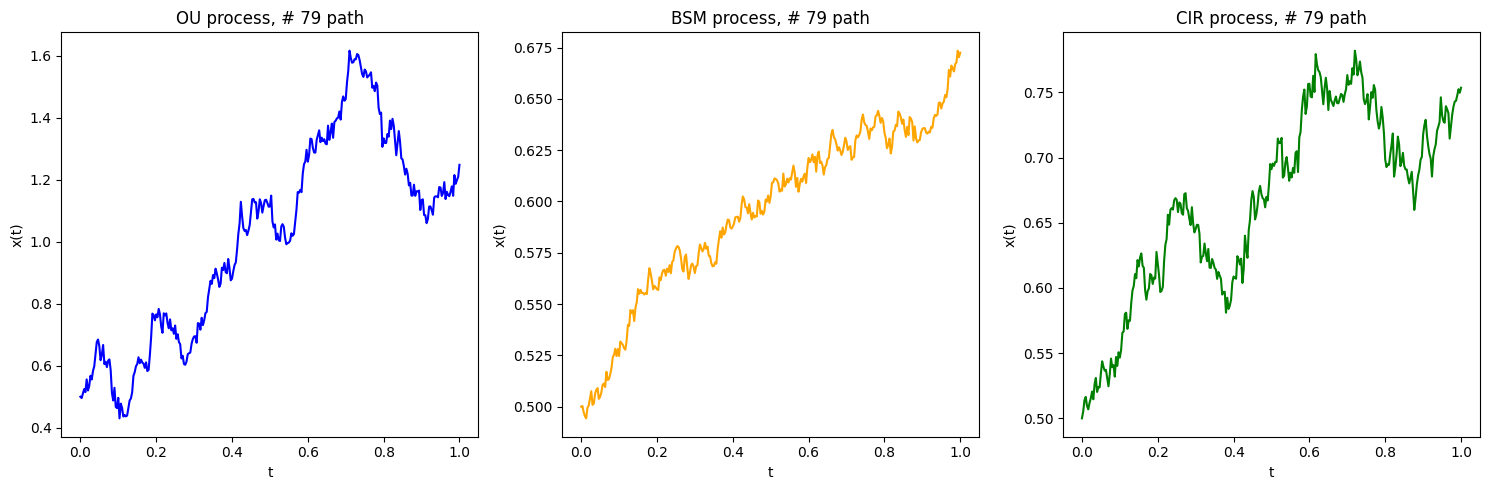

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

In [16]:
class ChanKarolyiLongstaffSanders(StochasticProcess):
    def init(self, params, T, Nx, Nt, init_state=None):
        super().init(params, T, Nx, Nt, init_state)
        self.theta1 = params[0]
        self.theta2 = params[1]
        self.theta3 = params[2]
        self.theta4 = params[3]

        if self.theta3 <= 0:
            raise ValueError("theta3 must be positive")

        if not ((self.theta1 == 0) or (self.theta4 == 1/2)):
            if not ((self.theta1 > 0) and (self.theta2 > 0) and (self.theta4 > 1/2)):
                raise ValueError("CKLS model conditions not met")

    def sampler_init_state(self):
        return np.random.uniform(0.1, 1, self.Nx)  # Initial state between 0.1 and 1

    def bxt(self, x):
        return self.theta1 + self.theta2 * x

    def sigmaxt(self, x):
        return self.theta3 * x**self.theta4

    def sigmaxt_x(self, x):
        return self.theta3 * self.theta4 * x**(self.theta4-1)

    def sigmaxt_xx(self, x):
        return self.theta3 * self.theta4 * (self.theta4-1) * x**(self.theta4-2)


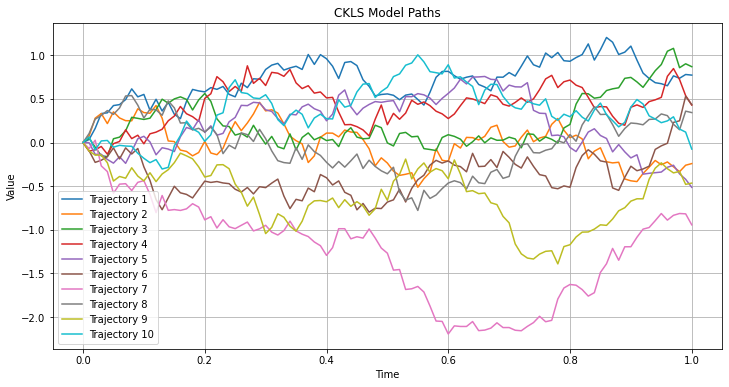

In [19]:
params = [0.1, 0.2, 0.3, 0.6]
T = 1
Nx = 10
Nt = 100
ckls_model = ChanKarolyiLongstaffSanders(params, T, Nx, Nt)
t_data, x_data = ckls_model.PathGenerator()

plt.figure(figsize=(12, 6))
for i in range(Nx):
    plt.plot(t_data, x_data[:, i], label=f'Trajectory {i + 1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('CKLS Model Paths')
plt.legend()
plt.grid(True)
plt.show()

Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [21]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

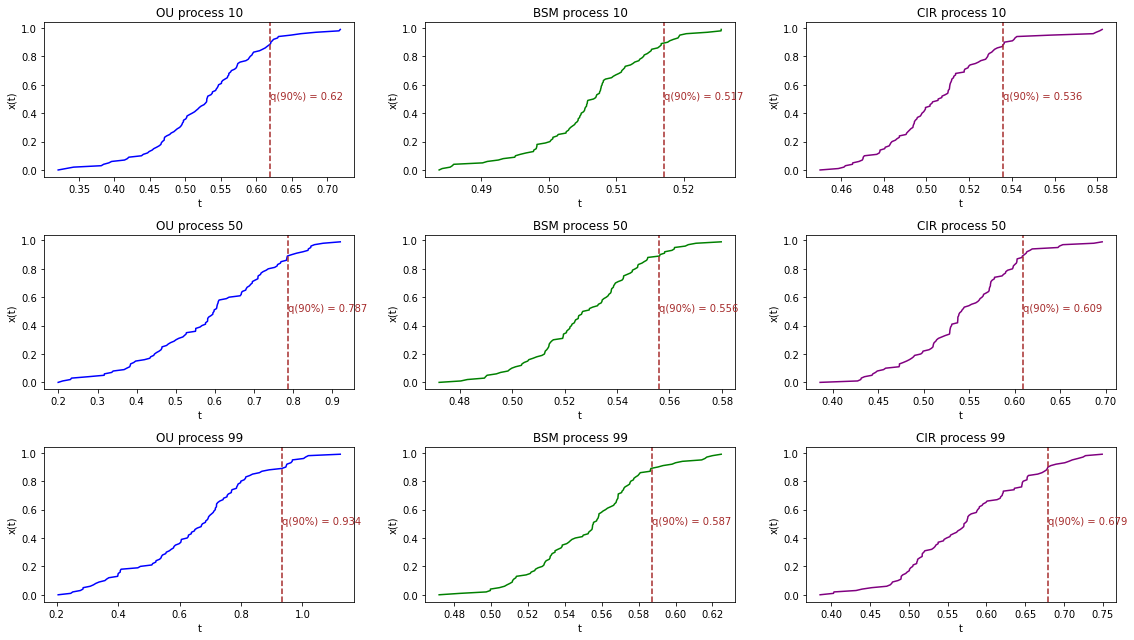

In [24]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[0][0].axvline(val, color='brown', linestyle='--')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[0][1].axvline(val, color='brown', linestyle='--')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[0][2].axvline(val, color='brown', linestyle='--')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[1][0].axvline(val, color='brown', linestyle='--')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[1][1].axvline(val, color='brown', linestyle='--')


axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[1][2].axvline(val, color='brown', linestyle='--')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[2][0].axvline(val, color='brown', linestyle='--')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[2][1].axvline(val, color='brown', linestyle='--')


axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')
axs[2][2].axvline(val, color='brown', linestyle='--')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

In [29]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(x_data_OU[n], x_data_BSM[n])

alpha = 0.05
# H0: Выборки одного распределения
if p_value > alpha:
    print("H0 не отвергается")
else:
    print("H0 отвергается")

H0 отвергается


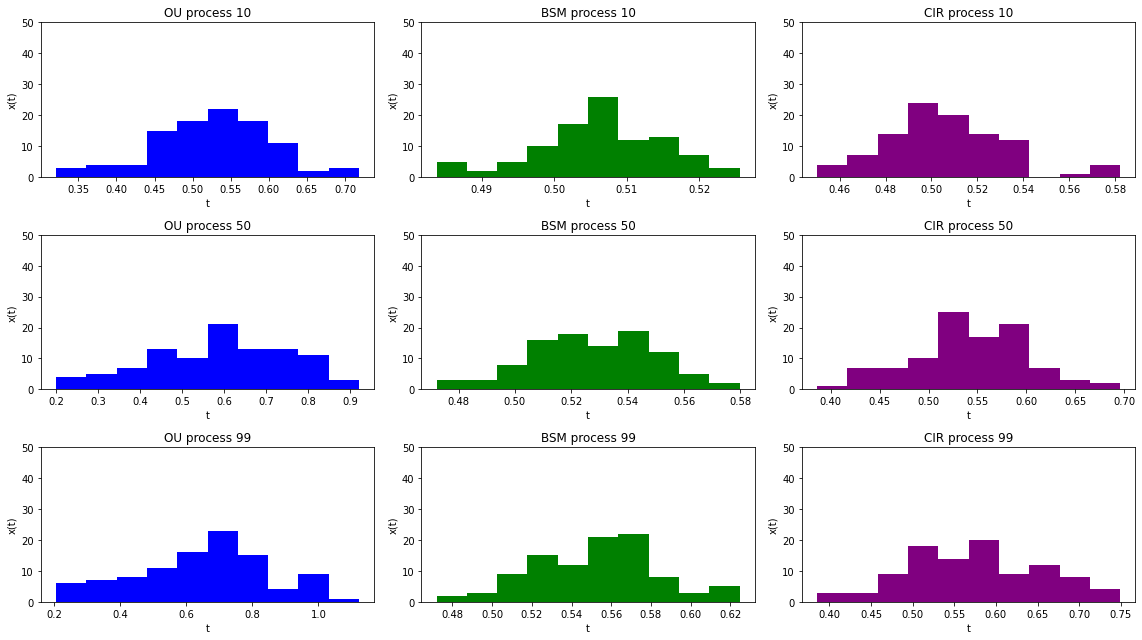

In [30]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 50)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

In [35]:
from scipy.stats import normaltest

print("OU process:")
print("p-value t=10:", normaltest(x_data_OU[10])[1])
print("p-value t=Nt/2:", normaltest(x_data_OU[Nt//2])[1])
print("p-value t=Nt-1:", normaltest(x_data_OU[Nt-1])[1])

print("\nBSM process:")
print("p-value t=10:", normaltest(x_data_BSM[10])[1])
print("p-value t=Nt/2:", normaltest(x_data_BSM[Nt//2])[1])
print("p-value t=Nt-1:", normaltest(x_data_BSM[Nt-1])[1])

print("\nCIR process:")
print("p-value t=10:", normaltest(x_data_CIR[10])[1])
print("p-value t=Nt/2:", normaltest(x_data_CIR[Nt//2])[1])
print("p-value t=Nt-1:", normaltest(x_data_CIR[Nt-1])[1])

print("Если p-value >= 0,05, мы не отвергаем нулевую гипотезу о том, что данные распределены нормально.")
print("Если p-value < 0.05, мы отвергаем нулевую гипотезу о том, что данные распределены нормально.")

OU process:
p-value t=10: 0.5369881659296281
p-value t=Nt/2: 0.22373433177270005
p-value t=Nt-1: 0.505402326447047

BSM process:
p-value t=10: 0.23052711352221678
p-value t=Nt/2: 0.7740644539711258
p-value t=Nt-1: 0.995534493957302

CIR process:
p-value t=10: 0.018233254339912693
p-value t=Nt/2: 0.8798468201418967
p-value t=Nt-1: 0.518738591591012
Если p-value >= 0,05, мы не отвергаем нулевую гипотезу о том, что данные распределены нормально.
Если p-value < 0.05, мы отвергаем нулевую гипотезу о том, что данные распределены нормально.
